Данный файл содержит в себе наши эксперименты с данными. Для работы загрузили следующие библиотеки.

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

Здесь открываем файл, удаляем пустые столбцы, называем оставшиеся столбцы.

In [280]:
colnames=['Ind', 'Time', 'Z', 'Temp', 'Pulse', '1', '2', 'O1', 'O2', '3', '4', '5', '6', '7', 'R1', 'R2', '8', '9'] 
df = pd.read_csv('Data/f1c2a950-0aa4-442b-b3f3-6cc933f79989/2022.04.12 0700.csv', header=None, names=colnames, delimiter=';')
df.dropna(axis='columns', how='all', inplace=True)
df['Time'] = df['Time'].str.replace(',', '').astype('int64')
df.head()

,Ind,Time,Z,Temp,Pulse,O1,O2,R1,R2
0,0,15,182.0,34.99,NaN,NaN,NaN,60319.0,29838.0
1,1,302280,181.0,34.61,NaN,NaN,235.0,60204.0,29765.0
2,2,605320,NaN,35.13,NaN,NaN,356.0,NaN,NaN
3,3,607062,184.0,NaN,NaN,NaN,NaN,61117.0,30260.0
4,4,623930,NaN,NaN,113.0,77.53,NaN,NaN,NaN


Выведем график зависимости индекса от времени записи, как видно на изображении записи можно кластеризовать, для комбинации отсутствующих полей и избавления от проблемы ассинхронной записи.

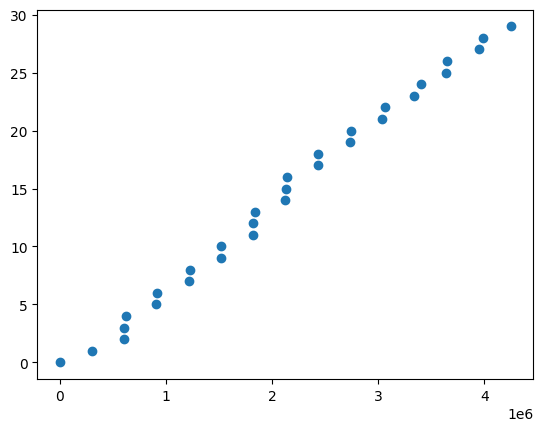

In [281]:
plt.scatter(df['Time'].iloc[0:30], df['Ind'].iloc[0:30])

Для кластеризации использовали алгоритм MeanShift, зависимость параметра quantile от размера выборки была обнаружена и установлена экспериментальным путем.

In [282]:
array = np.vstack((df['Time'].to_numpy(), df['Ind'].to_numpy())).T
bandwidth = estimate_bandwidth(array, quantile=3.8/len(array)+0.00085, n_samples=len(array))
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(array)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 43


Цветом показаны различные кластеры, в которые были сгрупированы записи.

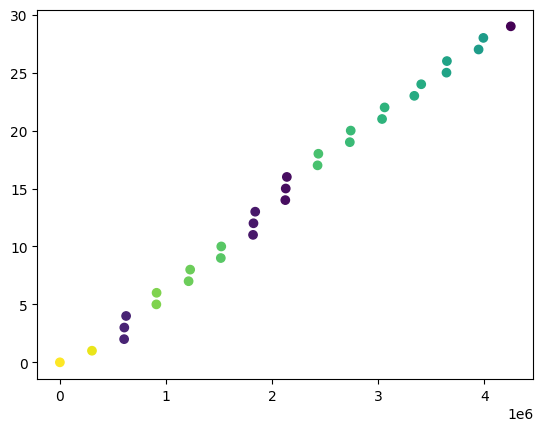

In [283]:
plt.scatter(array[0:30, 0], array[0:30, 1], c=labels[0:30], label=labels[0:30])

Далее необходимо было объединить записи находящиеся в одном кластере.

In [284]:
colnames_new = list(df.columns)
df_new = df.drop(df.index)

cur_label = -1
cur_row = []
cur_num = []

for i in range(0, len(labels)):
    if (labels[i] != cur_label):
        if (cur_label != -1):
            for j in range(1, len(cur_row)):
                if (cur_num[j] != 0):
                    cur_row[j] /= cur_num[j]
            df_new.loc[len(df_new)] = cur_row

        cur_label = labels[i]
        cur_row = df.iloc[[array[i][1]]].to_numpy()[0]
        cur_row[np.isnan(cur_row)] = 0
        cur_num = np.zeros(len(cur_row))
        for j in range(len(cur_row)):
            if (cur_row[j] > 0):
                cur_num[j] = 1
    else:
        tmp_row = df.iloc[[array[i][1]]].to_numpy()[0]
        tmp_row[np.isnan(tmp_row)] = 0
        tmp_num = np.zeros(len(tmp_row))
        for j in range(1, len(tmp_row)):
            if (tmp_row[j] > 0):
                cur_num[j] += 1
                cur_row[j] += tmp_row[j]
if (cur_label != -1):
        for j in range(1, len(cur_row)):
            if (cur_num[j] != 0):
                cur_row[j] /= cur_num[j]
        df_new.loc[len(df_new)] = cur_row

df = df_new
df_new.head()

,Ind,Time,Z,Temp,Pulse,O1,O2,R1,R2
0,0.0,15.0,182.0,34.99,0.0,0.00,0.0,60319.0,29838.0
1,1.0,302280.0,181.0,34.61,0.0,0.00,235.0,60204.0,29765.0
2,2.0,612104.0,184.0,35.13,113.0,77.53,356.0,61117.0,30260.0
3,5.0,910045.5,184.0,34.77,103.0,33.93,616.0,61194.0,30278.0
4,7.0,1220152.5,181.0,34.16,103.0,57.21,624.0,60793.0,30721.0


Далее иследуем зависимость различных параметров от времени, исследовав некоторые медицинские статьи на различных информационных ресурсах, обнаружили установленную зависимость температуры, электрической активности кожи и пульса, от уровня стресса. Пульс:

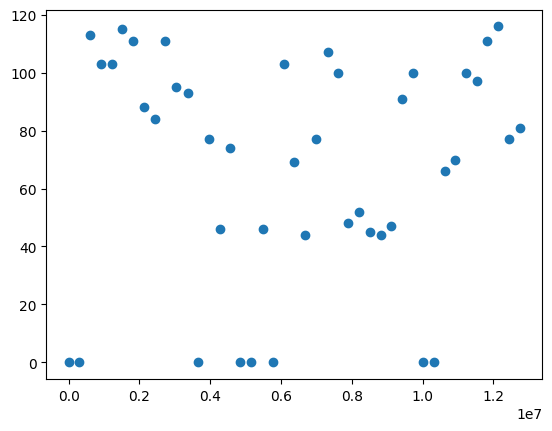

In [285]:
plt.scatter(df['Time'], df['Pulse'])

Температура тела:

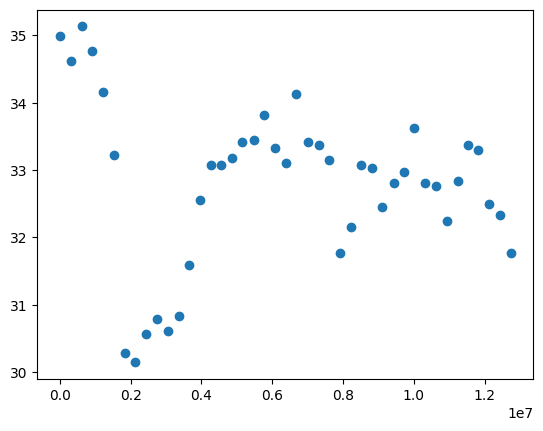

In [286]:
plt.scatter(df['Time'], df['Temp'])

Электрическая активность кожи:

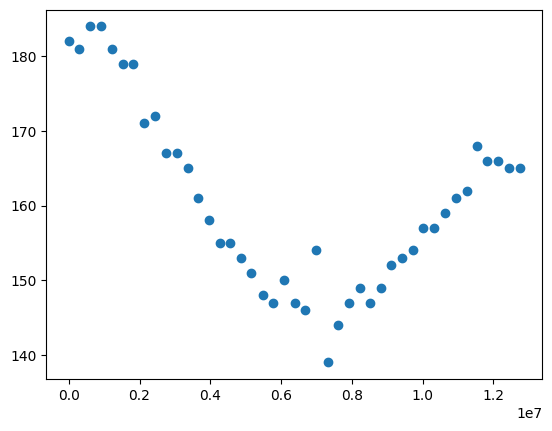

In [287]:
plt.scatter(df['Time'], df['Z'])

Значение сопротивления кожи 1:

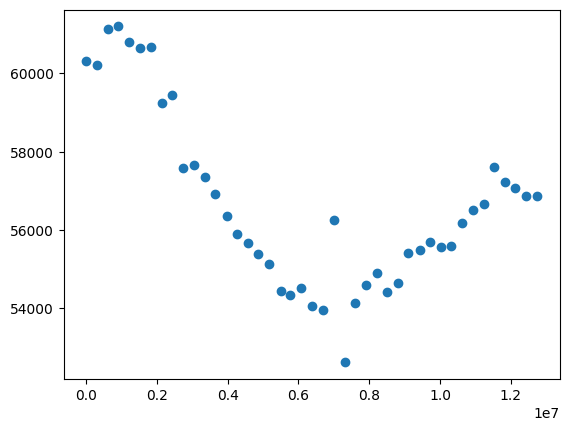

In [288]:
plt.scatter(df['Time'], df['R1'])

Значение сопротивления кожи 2: 

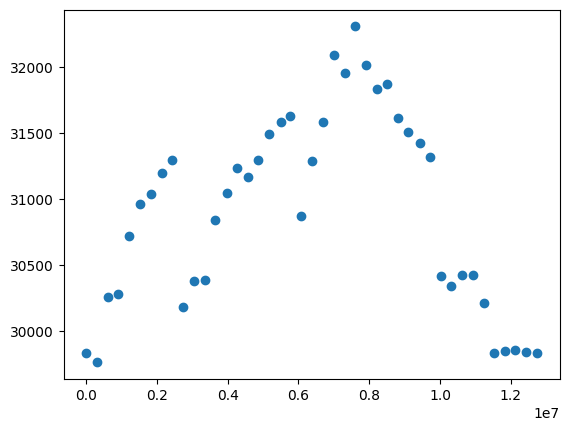

In [289]:
plt.scatter(df['Time'], df['R2'])